In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Make crops, not war

## Milestone 2

1) That you can handle the data in its size.

The datasets obtained from FAO are quite small in size as we can pre-filter the features that we are interested in before downloading them from the FAO website. 
    
2) That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).

We have begun to clean our data and the formats are clear and understandable. The missing values for our war data have been filled manually. As for the FAO dataset, ... 

3) That you considered ways to enrich, filter, transform the data according to your needs.

4) That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
    
5) That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

## Data size

### Wars Datasets

For the wars, we are going to use data got from [Wikidata Query Service](https://query.wikidata.org/) and then we only have the data we need, which is quite small as we can see below:

In [2]:
wikipedia_path = 'data/wikipedia/'
state_in_war_file = 'states.json'
political_in_war_file = 'political.json'
terroristic_in_war_file = 'terroristic.json'

wars_states_df = pd.read_json(wikipedia_path + state_in_war_file, orient='records', encoding='utf-8')
wars_political_df = pd.read_json(wikipedia_path + political_in_war_file, orient='records', encoding='utf-8')
wars_terroristic_df = pd.read_json(wikipedia_path + terroristic_in_war_file, orient='records', encoding='utf-8')

Since, at least for the moment, we are not interested in the difference between these three categories, but only between state and non-state actors, we only mark whether a participant is state or non-state. Next we stack the dataframes to create a unique one.

In [3]:
wars_states_df['is_state'] = True
wars_political_df['is_state'] = False
wars_terroristic_df['is_state'] = False

raw_wars_df = wars_states_df.append(wars_political_df, sort=True).append(wars_terroristic_df, sort=True)

renamed_wars_df = raw_wars_df.rename(columns={
    'armed_conflictLabel': 'name',
    'participantLabel': 'participant',
    'countryWarLabel': 'country',
    'locationLabel': 'location'
})

print(f"Length of wars dataframe: {renamed_wars_df.size}")

Length of wars dataframe: 8015


The dataframe can be kept in memory.

### Agriculture and Food Datasets

For food-related data, we are using data from [FAOSTAT](http://www.fao.org/faostat/en/#data) service. Here we can query FAO database as well, then we can download only the datasets we need. Particularly, we are interested in the following datasets:

- [Crops](http://www.fao.org/faostat/en/#data/QC)
- [Live Animals](http://www.fao.org/faostat/en/#data/QA)
- [Crops and livestock products](http://www.fao.org/faostat/en/#data/TP)
- [Annual Population](http://www.fao.org/faostat/en/#data/OA)
- [Land Use](http://www.fao.org/faostat/en/#data/RL)

Also these datasets are quite small and can be kept in memory.

In [4]:
fao_path = 'data/fao/'

crops_production_file = 'crops_production.csv'
livestock_production_file = 'livestock_production.csv'
trading_file = 'import_export.csv'
population_file = 'population.csv'
land_use_file = 'land_use.csv'

raw_crops_production_df = pd.read_csv(fao_path + crops_production_file, encoding='latin-1')
raw_livestock_production_df = pd.read_csv(fao_path + livestock_production_file, encoding='latin-1')
raw_trading_df = pd.read_csv(fao_path + trading_file, encoding='latin-1')
raw_population_df = pd.read_csv(fao_path + population_file, encoding='latin-1')
raw_land_use_df = pd.read_csv(fao_path + land_use_file, encoding='latin-1')

agricultural_dfs_names = ['crops', 'livestock', 'trading', 'population', 'land']

agricultural_dfs = [
    raw_crops_production_df,
    raw_livestock_production_df,
    raw_trading_df,
    raw_population_df,
    raw_land_use_df
]

for name, df in zip(agricultural_dfs_names, agricultural_dfs):
    print(f"Length of {name} dataframe: {df.size}")

Length of crops dataframe: 1437366
Length of livestock dataframe: 472752
Length of trading dataframe: 6933270
Length of population dataframe: 223725
Length of land dataframe: 170100


All these datasets can be easily handled by a laptop.

## Formats

Now, let us check the format of the dataframes

In [5]:
renamed_wars_df.dtypes

name            object
country         object
end_year       float64
is_state          bool
location        object
participant     object
start_year       int64
dtype: object

The other two wars dataframes have the same formats. We can see that the years have different types. It can be useful to convert them to `datetime` years.

## Missing values

### Wars Dataset

Let us check whether there are missing values in the wars dataframe:

In [6]:
print("Number of wars with missing data: " + 
      str(renamed_wars_df[renamed_wars_df.isnull().any(axis=1)].groupby('name').count().shape[0]))

print("Columns with missing data:")
renamed_wars_df.columns[renamed_wars_df.isnull().any()].tolist()

Number of wars with missing data: 36
Columns with missing data:


['country', 'end_year', 'location']

We can see that 36 wars that have missing values: due to how the Wikidata query is made, the wars without end date have not finish yet. So we can fill the value with the current year:

In [7]:
from datetime import datetime

renamed_wars_df.loc[renamed_wars_df['end_year'].isnull(), 'end_year'] = datetime.now().year

In [8]:
renamed_wars_df['start_year'] = pd.to_datetime(renamed_wars_df['start_year'], format='%Y')
renamed_wars_df['end_year'] = pd.to_datetime(renamed_wars_df['end_year'].astype(int), format='%Y')

Now, let us see check how many wars are missing country or location:

In [9]:
print("Number of wars with missing data: " + 
      str(renamed_wars_df[renamed_wars_df.isnull().any(axis=1)].groupby('name').count().shape[0]))

Number of wars with missing data: 20


Since they are not very much, we can fill the country manually, and since we are not interested in the precise location of the wars, we can drop the column.

In [10]:
non_null_wars_df = renamed_wars_df.copy()

# Fix missing country
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tet Offensive', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Kosovo War', 'country'] = 'Kosovo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Soviet–Afghan War', 'country'] = 'Afghanistan'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Cambodian Civil War', 'country'] = 'Cambodia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'First Congo War', 'country'] = 'Democratic Republic of the Congo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Djiboutian Civil War', 'country'] = 'Djibouti'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Libyan–Egyptian War', 'country'] = 'Lybia,Egypt'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Paquisha War', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Sino-Vietnamese War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == '1982 Ethiopian–Somali Border War', 'country'] = 'Somalia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Ceneps Guar', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Second Kurdish–Iraqi War', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Vietnam War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Six-Day War', 'country'] = 'Israel,Egypt,Palestine,Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == '2003 invasion of Iraq', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == '2014 Israel–Gaza conflict', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == '2018–19 Gaza border protests', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Croatian War of Independence', 'country'] = 'Croatia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel conflict', 'country'] = 'Palestine, Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Insurgency in the Maghreb (2002–)', 'country'] = '''
    Algeria,Libya,Mauritania,Morocco,Tunisia,Western Sahara'''
non_null_wars_df.loc[non_null_wars_df['name'] == "Lord's Resistance Army insurgency", 'country'] = '''
    Uganda,South Sudan,Democratic Republic of the Congo,Central African Republic'''

# Eplode entries with multiple locations
non_null_wars_df['country'] = non_null_wars_df['country'].str.split(',')
exploded_wars_df = non_null_wars_df.reset_index().explode('country').drop('index', axis=1)
stripped_wars_df = exploded_wars_df.copy()
stripped_wars_df['country'] = exploded_wars_df['country'].str.strip()

Let us see what is left:

In [11]:
stripped_wars_df[stripped_wars_df['country'].isnull()]

,name,country,end_year,is_state,location,participant,start_year
767,War on Terror,NaN,2019-01-01,True,NaN,People's Republic of China,2001-01-01
768,War on Terror,NaN,2019-01-01,True,NaN,France,2001-01-01
769,War on Terror,NaN,2019-01-01,True,NaN,Islamic State of Iraq and the Levant,2001-01-01
770,War on Terror,NaN,2019-01-01,True,NaN,Russia,2001-01-01
771,War on Terror,NaN,2019-01-01,True,NaN,United Kingdom,2001-01-01
772,War on Terror,NaN,2019-01-01,True,NaN,United States of America,2001-01-01
1059,War on Terror,NaN,2019-01-01,False,NaN,Islamic State of Iraq and the Levant,2001-01-01
1060,War on Terror,NaN,2019-01-01,False,NaN,Taliban,2001-01-01
1061,War on Terror,NaN,2019-01-01,False,NaN,Turkistan Islamic Party,2001-01-01
1086,War on Terror,NaN,2019-01-01,False,NaN,Islamic State of Iraq and the Levant,2001-01-01


Since the [War on Terror](https://en.wikipedia.org/wiki/War_on_Terror) can be considered as a series of war, and has no defined location, we drop it.

In [12]:
final_wars_df = stripped_wars_df[stripped_wars_df['name'] != 'War on Terror']

### Food related datasets

Let us first see the different unique in the features, in order to decide if we can drop them:

In [13]:
raw_crops_production_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
A,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669


In [14]:
raw_crops_production_df.groupby('Unit').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Value,Flag,Flag Description
Unit,,,,,,,,,,,,,
tonnes,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [15]:
raw_crops_production_df.groupby('Element').count()

,Domain Code,Domain,Area Code,Area,Element Code,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Element,,,,,,,,,,,,,
Production,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [16]:
raw_crops_production_df.groupby('Domain').count()

,Domain Code,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Domain,,,,,,,,,,,,,
Crops,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


Since we have only one value for those columns, we can drop them. We just need to keep in mind that the unit used is tonnes. Let us drop useless columns, and rename the remaing ones to be more consistent with the wars dataframe naming.

In [17]:
def drop_useless_columns(fao_df):

    fao_df = fao_df.drop(columns=[
        'Domain Code',
        'Area Code',
        'Domain',
        'Element Code',
        'Element',
        'Item Code',
        'Year Code',
        'Unit',
        'Flag',
        'Flag Description'
    ])
    
    try:
        fao_df = fao_df.drop('Note', axis=1)
    except KeyError:
        pass
    
    try:
        fao_df = fao_df.drop('Unnamed: 0', axis=1)
    except KeyError:
        pass

    fao_df = fao_df.rename(columns={
        'Area': 'country',
        'Item': 'item',
        'Year': 'year',
        'Value': 'value'
    })

    fao_df['year'] = pd.to_datetime(fao_df['year'], format='%Y')
    
    return fao_df

dropped_agricultural_dfs = list(map(drop_useless_columns, agricultural_dfs))

Now, let us see if there are missing values:

In [18]:
for name, df in zip(agricultural_dfs_names, dropped_agricultural_dfs):
    print("In the {name} dataset there are {missing} missing values.".format(
        name=name,
        missing=df[df.isnull().any(axis=1)].size
    ))

In the crops dataset there are 8744 missing values.
In the livestock dataset there are 1512 missing values.
In the trading dataset there are 132140 missing values.
In the population dataset there are 0 missing values.
In the land dataset there are 0 missing values.


We can see that many values are missing. However, since we are going to aggregate the data, we assume that the impact of missing data will be low. Moreover, we will need to know in which years we are missing data, in order to weight better the averages we are going to compute. When we will need more specific data about some particular countries, we will decide how to handle the problem in a more elaborate way.

## Distributions

We are now going to see the distribution of the number of years in which a country had a war.

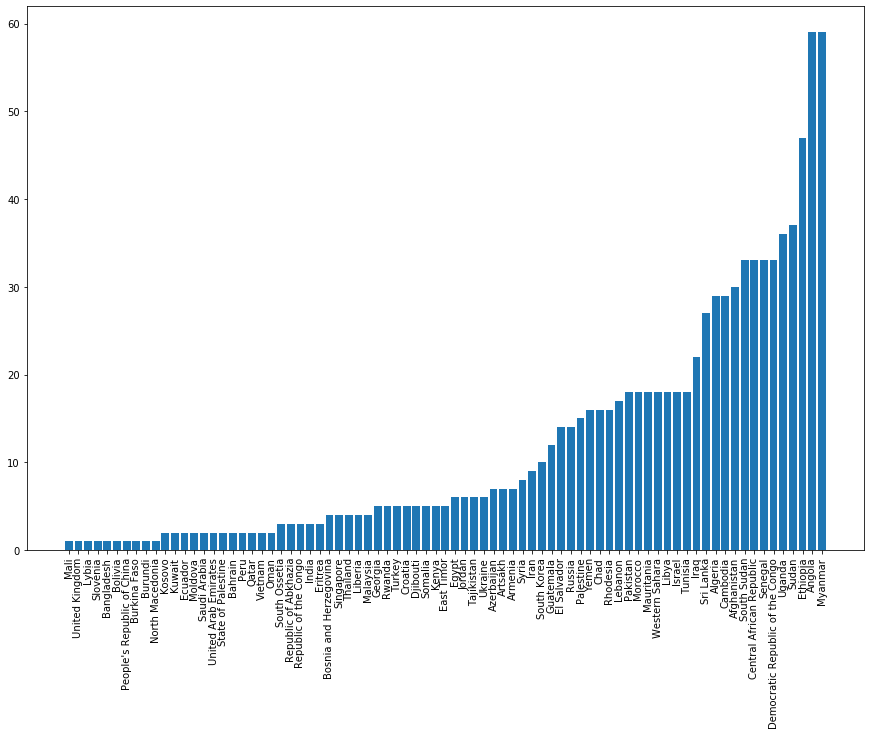

In [34]:
country_wars_df = final_wars_df.groupby(['country', 'name', 'start_year', 'end_year']).count().reset_index()

country_wars_df['range'] = country_wars_df.apply(
    lambda row: list(range(row['start_year'].year, row['end_year'].year + 1)),
    axis=1
)

unique_years_df = country_wars_df.explode('range')[['country', 'range']].drop_duplicates().reset_index().drop('index', axis=1)

years_per_country = unique_years_df.groupby('country').count().sort_values(by='range').reset_index()

plt.figure(figsize=(15,10))
plt.bar(years_per_country['country'], years_per_country['range'])
_ = plt.xticks(rotation=90)

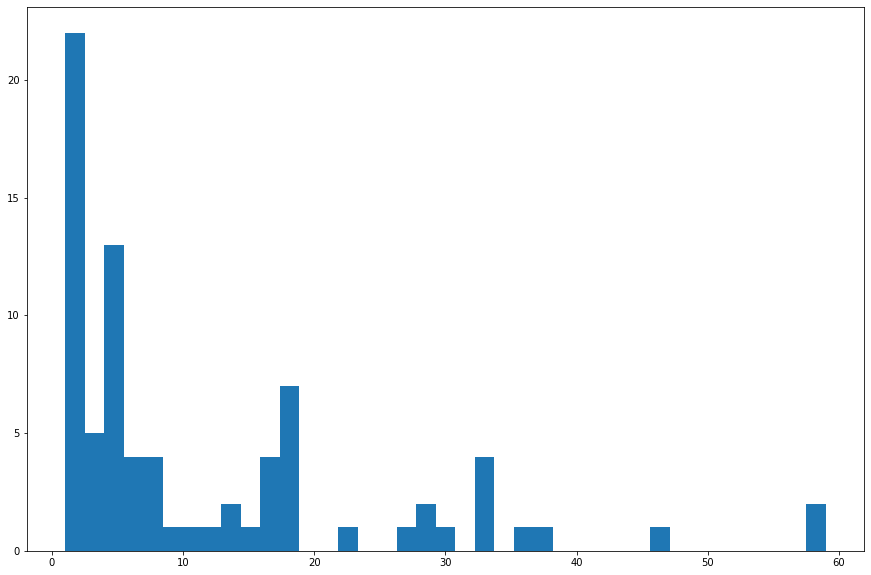

In [44]:
plt.figure(figsize=(15,10))
_ = plt.hist(years_per_country['range'], bins=years_per_country.shape[0] // 2)